# A Simple Scaling Relation 

In this test we consider an ensemble of galaxies with observed stellar and (somehow) dark halo masses, which we assume (correctly) to be related by a simple scaling relation, with intrinsic scatter. We wish to learn the parameters of the population. Here is the model.

Halo masses (in log units) are drawn from a Gaussian distribution: $\log{M_h} \sim \mathcal{N}(\mu_h, \sigma_h)$

Stellar masses are drawn from a Gaussian distribution with mean that scales with halo mass: $\log{M_*} \sim \mathcal{N}(\mu_* + \beta(\log{M_h} - 13), \sigma_*)$. In other terms, halo and stellar masses are drawn from a multivariate Gaussian

$\rm{Pr}(\log{M_h}, \log{M_*}) = \frac{1}{2\pi|C|^{1/2}}\exp{\left\{ - \frac12(\vec{m} - \vec{\mu})^\intercal C^{-1} (\vec{m} - \vec{\mu})\right\}}$

with $\vec{m} = (\log{M_h}, \log{M_*})$, $\vec{\mu} = (\mu_h, \mu_* + \beta(\mu_h - 13))$ and $C = \left(\begin{array}{cc} \sigma_h^2 & \beta\sigma_h^2\\ \beta\sigma_h^2 & \sigma_*^2 + \beta^2\sigma_h^2\end{array}\right)$

Measurements of $\log{M_h}$ and $\log{M_*}$, ($\log{M_h^{\mathrm{(obs)}}}$ and $\log{M_*^{\mathrm{(obs)}}}$) are drawn from Gaussian distributions centered on the true value and with dispersion $\epsilon_h$, $\epsilon_*$, uncorrelated.

$\epsilon_h$ and $\epsilon_*$ are constant over the sample and are known exactly by the observer.

In [4]:
# !pip install --upgrade daft

In [14]:
# %load Simple_Mstar_Mh_PGM.py

In [15]:
simple_Mstar_Mh_PGM()

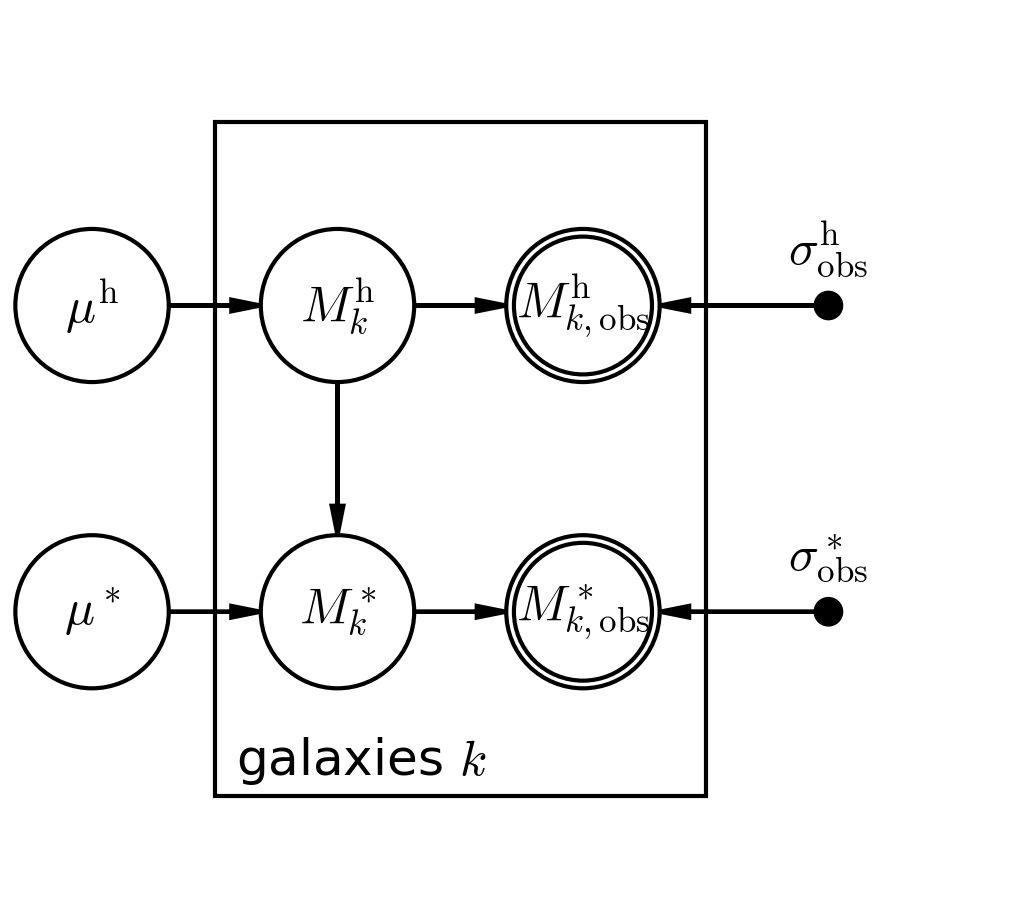

In [16]:
from IPython.display import Image
Image(filename="Simple_Mstar_Mh_PGM.png")

We can generate the mock as follows

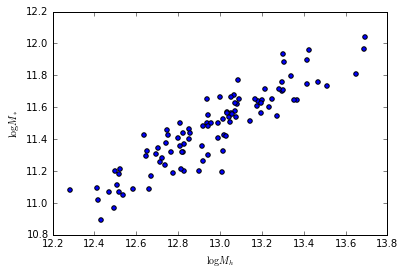

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the number of objects
nobj = 100

# specify the values of the hyperparameters
mu_h = 13.
sig_h = 0.3

mu_star = 11.5
sig_star = 0.1
beta = 0.8

err_h = 0.1
err_star = 0.1

# draws values of mhalo
mhalo = np.random.normal(mu_h, sig_h, nobj)

# draws values of mstar
mstar = np.random.normal(mu_star + beta*(mhalo - 13.), sig_star, nobj)

# adds noise
mhalo_obs = mhalo + np.random.normal(0., err_h, nobj)
mstar_obs = mstar + np.random.normal(0., err_star, nobj)

# makes a scatter plot of the sample
plt.scatter(mhalo, mstar)
plt.xlabel('$\log{M_h}$')
plt.ylabel('$\log{M_*}$')
plt.show()

We wish to infer the values of the hyperparameters $\mu_h$, $\sigma_h$, $\mu_*$, $\sigma_*$ and $\beta$.
We can do it with a hierarchical inference method, in which we sample the posterior probability distribution of the hyperparameters given the data, and marginalize over the individual halo and stellar masses of our galaxies.

${\rm Pr}(\mu, C|\vec{d}) \propto {\rm Pr}(\mu, C){\rm Pr}(\vec{d}|\mu, C) = {\rm Pr}(\mu, C)\prod_k\int d\vec{m}_k {\rm Pr}(\vec{d}_k|\vec{m}_k){\rm Pr}(\vec{m}_k|\mu, C)$

Since everything is Gaussian, we can do the integral over $\log{M_h}$ and $\log{M_*}$ analytically and sample over the hyperparameters with an MCMC. Let's do that.

In [6]:
from toy_models import hierarchical_inference as hi

# stores the values of hyperparameters used to generate the mock in a dictionary, which is then passed to the
# inference code, so it can start from the true values.

truth = {'mhalo_mu': mu_h, 'mhalo_sig': sig_h, 'mstar_mu': mu_star, 'mstar_sig': sig_star, 'mstar_mhalo': beta}
mock = {'truth': truth}

chain = hi.infer_simple_reality_knownimf_nocosmo_analytic(mock, mhalo_obs, err_h*np.ones(nobj), mstar_obs, \
                                                          err_star*np.ones(nobj), nstep=15000, burnin=5000)

 [-----------------89%--------------    ] 13486 of 15000 complete in 241.9 sec

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pymc/StepMethods.py:1265: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)
/gdrive/projects/allZeLenses/toy_models/hierarchical_inference.py:194: RuntimeWarning: overflow encountered in exp
  np.dot(prod_mu.T, np.dot(prod_invcov, prod_mu))))


 [-----------------100%-----------------] 15000 of 15000 complete in 256.8 sec

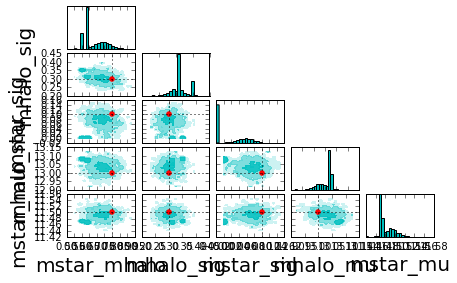

In [9]:
from allZeTools.plotters import cornerplot

cp = []
for par in truth:
    cp.append({'data': chain[par], 'label': par, 'value': truth[par]})
    
cornerplot(cp, color='c')
plt.show()